# ARIMA Algorithm for Stock Price Data 

This algorithm takes several stocks and runs it through the ARIMA model to produce forecasts. 

In [1]:
import pandas as pd
import numpy as np 
import requests
from datetime import date, timedelta
import json
import io
from pandas.io.json import json_normalize
import math
from stock_price_credentials import credentials

# Set up

First, select your date parameters.

In [2]:
today = date.today() 
end_date = today - timedelta(days=1) # do not include todays prices
start_date = today - timedelta(days=365 + 1) # pull one year of data
total_days = end_date - start_date

print("Today: " + str(today))
print("Start Date: " + str(start_date))
print("End Date: " + str(end_date))
print("Number of Days: " + str(total_days))

Today: 2022-11-28
Start Date: 2021-11-27
End Date: 2022-11-27
Number of Days: 365 days, 0:00:00


Select the stocks you want to pull data for.

Note: This is still a WIP, once complete this algorithm will loop through all of the chosen stock symbols. 
The API used for this only allows for pulling historical data for one symbol at a time. 

In [3]:
stock_symbols = {'AAPL, BNS'}
out_of_sample_forecasting_days = 10 # specify the number of days forward you want to forecast 

Pull the data. 

In [4]:
url = credentials['url']

parameters = {
    'api_token': credentials['api_token'],
    'symbols': 'AAPL', 
    'date_from': start_date,
    'date_to': end_date, 
    'sort': 'asc'
}

r = requests.get(url, params=parameters).content # pull the data 
jsonResponse = json.loads(r.decode('utf-8')) # transform it into json object 
df = json_normalize(jsonResponse['data']) # save it in a data frame 
df['date'] = pd.to_datetime(df["date"], format="%Y-%m-%d").dt.date # format the date 

/var/folders/g9/xz2w6yy92t709mhgv2kwzl480000gn/T/ipykernel_96832/886783440.py:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = json_normalize(jsonResponse['data']) # save it in a data frame


In [5]:
df

,date,open,high,low,close,volume
0,2021-11-29,159.37,161.19,158.79,160.24,88748217
1,2021-11-30,159.99,165.52,159.92,165.30,174048056
2,2021-12-01,167.48,170.30,164.53,164.77,152423003
3,2021-12-02,158.74,164.20,157.80,163.76,136739174
4,2021-12-03,164.02,164.96,159.72,161.84,118023116
...,...,...,...,...,...,...
246,2022-11-18,152.31,152.70,149.97,151.29,74829573
247,2022-11-21,150.16,150.37,147.72,148.01,58724070
248,2022-11-22,148.13,150.42,146.93,150.18,51804132
249,2022-11-23,149.45,151.83,149.34,151.07,58301395


# ARIMA Model Overview

The ARIMA model has three parameters: ARIMA(p,d,q)

- AR(p) is the autoregressive order
- MA(q) is the moving average parameter
- d is the differencing parameter

This algorithm chooses the optimal parameters and produces a final model. Below is an overview of how each parameter is determined. 

In this example we will be forecasting the closing price of each stock out into the future. 

### Choosing d

To do this we need to run the dickey fuller test. If the p-value > 0.05 the data is non-stationary and we need differencing. Similar for second differencing. It is rare that third order differencing is needed.

The APPL stock is non-stationary and differencing of an order d = 1 is required. 

In [6]:
from statsmodels.tsa.stattools import adfuller

first_diff = adfuller(df.close.dropna())
print('ADF Statistic First Differencing: %f' % first_diff[0])
print('p-value First Differencing: %f' % first_diff[1])

second_diff = adfuller(df.close.diff().dropna())
print('ADF Statistic Second Differencing: %f' % second_diff[0])
print('p-value Second Differencing: %f' % second_diff[1])

ADF Statistic First Differencing: -2.065574
p-value First Differencing: 0.258581
ADF Statistic Second Differencing: -16.248659
p-value Second Differencing: 0.000000


### Choosing p and q

Choosing the order of p and q is often done visually by investigation the autocorrelation and partial autocorrelation plots. 

Partial Autocorrelation: Chooses p
- the last lag outside of the 95% confidence band is p = 2
- we could test the model for p in [0,2]

Autocorrelation: Chooses q 
- the last lag outside of the 95% confidence band is q = 15
- we could test the model for q in [0,15]

However, a visual decision is not optimal and best practice is to choose the order of p and q that minimizes the AIC (Akaike information criterion) statistic. It is unlikely that a high AR(p) or MA(q) order will be optimal. 

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


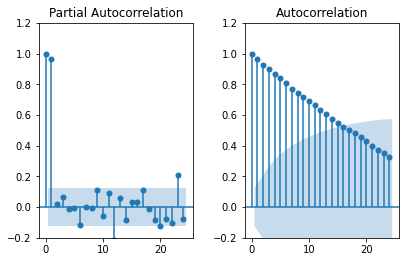

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharex=True)

plot_pacf(df.close, ax=axes[0], alpha=0.05)
axes[0].set(ylim=(-0.2,1.2))
plot_acf(df.close, ax=axes[1], alpha=0.05)
axes[1].set(ylim=(-0.2,1.2))

fig.tight_layout(pad=2.0)

plt.show()

## Functions for Producing the Parameters and Final Data Frame

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Choosing d.

In [9]:
def differencing_parameter(df):
    
    first_diff = adfuller(df.close.dropna())
    second_diff = adfuller(df.close.diff().dropna())

    if ((first_diff[1] > 0.05) and (second_diff[1] > 0.05)): 
        d = 2
    elif((first_diff[1] > 0.05) and (second_diff[1] <= 0.05)):
        d =1 
    else: 
        d = 0 
        
    return d 

Choosing AR(p) and MA(q) with the chosen d. 

In [10]:
def ARIMA_parameter_optimization(df):
    
    d = differencing_parameter(df)
    
    order_aic_bic =[]
    # Loop over AR order
    for p in range(8):
        # Loop over MA order
        for q in range(8):
            # Fit models
            model = SARIMAX(df['close'].dropna(), order=(p,d,q), trend='c')
            results = model.fit()
            # Add order and statistics to list
            order_aic_bic.append((p, d, q, results.aic, results.bic))
    
    # Save parameters to a data frame 
    order_df = pd.DataFrame(order_aic_bic, columns=['p','d','q', 'aic', 'bic'])
    
    # Select the parameters with the lowest AIC 
    parameter_df = order_df.loc[(order_df['aic'] == order_df['aic'].min())]
    
    return parameter_df

Running the final model based on the chosen parameters. 

In [11]:
def ARIMA_model(df):
    
    parameter_df = ARIMA_parameter_optimization(df)
    
    p = parameter_df['p'].mean()
    q = parameter_df['q'].mean()
    d = parameter_df['d'].mean()

    model = SARIMAX(df['close'].dropna(), order=(p,d,q), trend = 'c')
    model_fit = model.fit()
    
    return model_fit

Generating the out of sample forecast.

In [12]:
def out_of_sample_fcast(df):
    
    model_fit = ARIMA_model(df)
    output = model_fit.forecast()
    future_forecast = model_fit.get_forecast(steps=out_of_sample_forecasting_days).predicted_mean
    df_forecast = future_forecast.to_frame()
    
    return df_forecast

## This the the only function that is needed to produce the results and store it in a dataframe. 

The reccomendation is to save this script and import this function into a new script to run your forecast. 

In [13]:
def final_frame(df):
    
    df_forecast = out_of_sample_fcast(df)

    number_of_weekend_days = math.ceil(out_of_sample_forecasting_days/2) # account for weekends which need to be removed
    days = out_of_sample_forecasting_days + number_of_weekend_days # number of days we will extend the date column
    date_range = pd.DatetimeIndex(df['date']) + pd.Timedelta(days=days)

    date_range = date_range.to_frame() # save to a frame
    date_range['dotw'] = date_range['date'].dt.dayofweek # add day of week
    date_range = date_range[(date_range['dotw'] != 6) & (date_range['dotw'] != 0)] # remove weekends

    df = df.set_index('date') # set the index in the original data frame to the date colum
    df = date_range.join(df) # merge
    df = df.drop(['date'], axis=1).reset_index() # reset the index
    
    final_df = df_forecast.join(df)
    
    return final_df

In [14]:
results_df = final_frame(df)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64432D+00    |proj g|=  8.44302D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   8.443D-07   2.644D+00
  F =   2.6443217886722645     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63754D+00    |proj g|=  3.33921D-02

At iterate    5    f=  2.63652D+00    |proj g|=  1.32953D-03

At iterate   10    f=  2.63651D+00    |proj g|=  4.57327D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     14      1     0     0   7.109D-07   2.637D+00
  F =   2.6365122545210298     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.62983D+00    |proj g|=  2.13175D-03

At iterate   10    f=  2.62982D+00    |proj g|=  2.04273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     12     14      1     0     0   5.378D-06   2.630D+00
  F =   2.6298192016960686     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64389D+00    |proj g|=  1.68188D-03

At iterate    5    f=  2.64386D+00    |proj g|=  7.95541D-07

       

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   35    f=  2.63440D+00    |proj g|=  5.49579D-03

At iterate   40    f=  2.63440D+00    |proj g|=  4.00320D-04

At iterate   45    f=  2.63440D+00    |proj g|=  2.45682D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     72      1     0     0   3.898D-04   2.634D+00
  F =   2.6343950700765775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64103D+00    |proj g|=  6.89592D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.64037D+00    |proj g|=  4.14833D-02

At iterate   20    f=  2.63468D+00    |proj g|=  2.51122D-02

At iterate   25    f=  2.62493D+00    |proj g|=  1.31576D-02

At iterate   30    f=  2.62419D+00    |proj g|=  2.79768D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     41      1     0     0   2.321D-06   2.624D+00
  F =   2.6241922840276284     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f=  2.62396D+00    |proj g|=  5.85709D-03

At iterate   25    f=  2.62299D+00    |proj g|=  7.23553D-03

At iterate   30    f=  2.62295D+00    |proj g|=  1.23038D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     39      1     0     0   6.860D-06   2.623D+00
  F =   2.6229460397042494     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62996D+00    |proj g|=  4.47407D-02

At itera

 This problem is unconstrained.



At iterate    5    f=  2.62707D+00    |proj g|=  4.81761D-03

At iterate   10    f=  2.62271D+00    |proj g|=  2.09221D-02

At iterate   15    f=  2.62052D+00    |proj g|=  5.96646D-03

At iterate   20    f=  2.62012D+00    |proj g|=  1.13355D-03

At iterate   25    f=  2.62008D+00    |proj g|=  1.29530D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     29     34      1     0     0   7.800D-06   2.620D+00
  F =   2.6200759378156135     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.62441D+00    |proj g|=  5.00531D-03

At iterate   10    f=  2.62171D+00    |proj g|=  1.45294D-02

At iterate   15    f=  2.62022D+00    |proj g|=  7.78839D-03

At iterate   20    f=  2.62007D+00    |proj g|=  1.16903D-03

At iterate   25    f=  2.62007D+00    |proj g|=  2.51412D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     25     28      1     0     0   2.514D-05   2.620D+00
  F =   2.6200684737384261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.64074D+00    |proj g|=  1.78015D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   8.183D-06   2.641D+00
  F =   2.6407421050917410     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64074D+00    |proj g|=  2.69941D-03

At iterate    5    f=  2.64070D+00    |proj g|=  5.30802D-04

At iterate   10    f=  2.64069D+00    |proj g|=  1.90898D-04

       

 This problem is unconstrained.



At iterate   30    f=  2.61734D+00    |proj g|=  1.98049D-02

At iterate   35    f=  2.61611D+00    |proj g|=  2.70050D-02

At iterate   40    f=  2.61590D+00    |proj g|=  6.56877D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     60      1     0     0   5.889D-05   2.616D+00
  F =   2.6159016649421720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63621D+00    |proj g|=  4.93840D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  2.62290D+00    |proj g|=  1.81214D-01

At iterate   30    f=  2.61800D+00    |proj g|=  7.05385D-02

At iterate   35    f=  2.61746D+00    |proj g|=  4.82776D-02

At iterate   40    f=  2.61711D+00    |proj g|=  1.90090D-02

At iterate   45    f=  2.61655D+00    |proj g|=  9.71930D-03

At iterate   50    f=  2.61594D+00    |proj g|=  4.82006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   4.820D-03   2.616D+00
  F =   2.6159397498855537     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.64464D+00    |proj g|=  2.56717D-02

At iterate   10    f=  2.62300D+00    |proj g|=  2.38353D-03

At iterate   15    f=  2.62227D+00    |proj g|=  1.25800D-02

At iterate   20    f=  2.62159D+00    |proj g|=  9.08902D-03

At iterate   25    f=  2.62061D+00    |proj g|=  5.03723D-03

At iterate   30    f=  2.62008D+00    |proj g|=  5.18287D-04

At iterate   35    f=  2.62008D+00    |proj g|=  1.65208D-04

At iterate   40    f=  2.62008D+00    |proj g|=  1.55715D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     45      1     0     0   1.557D-05   2.620D+00
  F =   2.62008156860

 This problem is unconstrained.



At iterate   25    f=  2.61352D+00    |proj g|=  1.83066D-02

At iterate   30    f=  2.61301D+00    |proj g|=  1.40482D-02

At iterate   35    f=  2.61172D+00    |proj g|=  1.25295D-01

At iterate   40    f=  2.61082D+00    |proj g|=  1.09338D-02

At iterate   45    f=  2.61030D+00    |proj g|=  4.47480D-03

At iterate   50    f=  2.61027D+00    |proj g|=  1.58277D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60      1     0     0   1.583D-03   2.610D+00
  F =   2.6102700679889912     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  2.61766D+00    |proj g|=  1.28274D-02

At iterate   10    f=  2.61732D+00    |proj g|=  2.66958D-03

At iterate   15    f=  2.61714D+00    |proj g|=  4.77265D-04

At iterate   20    f=  2.61709D+00    |proj g|=  2.36173D-03

At iterate   25    f=  2.61699D+00    |proj g|=  1.59379D-04

At iterate   30    f=  2.61699D+00    |proj g|=  3.08815D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     30     34      1     0     0   3.088D-05   2.617D+00
  F =   2.6169856934824143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  2.64040D+00    |proj g|=  3.73084D-03

At iterate   20    f=  2.64010D+00    |proj g|=  9.75251D-03

At iterate   25    f=  2.63805D+00    |proj g|=  8.71044D-03

At iterate   30    f=  2.63402D+00    |proj g|=  2.01004D-02

At iterate   35    f=  2.63275D+00    |proj g|=  7.94945D-03

At iterate   40    f=  2.62808D+00    |proj g|=  5.32963D-02

At iterate   45    f=  2.61976D+00    |proj g|=  2.76406D-02

At iterate   50    f=  2.61399D+00    |proj g|=  4.27122D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   4.271D-02   2.614D+00
  F =   2.61398948608

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.64049D+00    |proj g|=  1.83061D-02

At iterate   10    f=  2.63712D+00    |proj g|=  3.67736D-02

At iterate   15    f=  2.61975D+00    |proj g|=  2.40651D-02

At iterate   20    f=  2.61585D+00    |proj g|=  1.10029D-02

At iterate   25    f=  2.60607D+00    |proj g|=  6.37853D-02

At iterate   30    f=  2.59831D+00    |proj g|=  1.90673D-02

At iterate   35    f=  2.59674D+00    |proj g|=  1.03615D-02

At iterate   40    f=  2.59661D+00    |proj g|=  2.81872D-03

At iterate   45    f=  2.59661D+00    |proj g|=  9.24134D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     55   

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   30    f=  2.59728D+00    |proj g|=  2.99952D-02

At iterate   35    f=  2.59681D+00    |proj g|=  5.32431D-03

At iterate   40    f=  2.59656D+00    |proj g|=  2.70882D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     52      1     0     0   2.275D-04   2.597D+00
  F =   2.5965466747016621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64527D+00    |proj g|=  8.98794D-02

At iter

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  2.61795D+00    |proj g|=  1.52356D-02

At iterate   20    f=  2.61345D+00    |proj g|=  5.74465D-02

At iterate   25    f=  2.60949D+00    |proj g|=  6.24598D-02

At iterate   30    f=  2.60062D+00    |proj g|=  6.03198D-02

At iterate   35    f=  2.59649D+00    |proj g|=  6.61834D-03

At iterate   40    f=  2.59640D+00    |proj g|=  1.77538D-03

At iterate   45    f=  2.59639D+00    |proj g|=  5.25094D-04


/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  2.59639D+00    |proj g|=  1.47153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   1.472D-04   2.596D+00
  F =   2.5963855313660811     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62045D+00    |proj g|=  2.32782D-02

At iterate    5    f=  2.61868D+00    |proj g|=  4.37481D-03

At iterate   10    f=  2.61730D+00    |proj g|=  3.24186D-02

At iter

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63009D+00    |proj g|=  6.54247D-02

At iterate    5    f=  2.61762D+00    |proj g|=  2.66095D-02

At iterate   10    f=  2.61632D+00    |proj g|=  1.29962D-02

At iterate   15    f=  2.61131D+00    |proj g|=  2.77689D-02

At iterate   20    f=  2.60228D+00    |proj g|=  5.24081D-02

At iterate   25    f=  2.59463D+00    |proj g|=  2.85287D-02

At iterate   30    f=  2.59310D+00    |proj g|=  1.44454D-02

At iterate   35    f=  2.59303D+00    |proj g|=  1.83917D-03

At iterate   40    f=  2.59300D+00    |proj g|=  3.71875D-04

At iterate   45    f=  2.59300D+00    |proj g|=  1.44474D-04


/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  2.59300D+00    |proj g|=  7.43818D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   7.438D-05   2.593D+00
  F =   2.5930020355665571     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64068D+00    |proj g|=  3.20316D-03

At iterate    5    f=  2.64066D+00    |proj g|=  1.25015D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   25    f=  2.59962D+00    |proj g|=  1.23946D-02

At iterate   30    f=  2.59682D+00    |proj g|=  1.47387D-02

At iterate   35    f=  2.59657D+00    |proj g|=  1.39442D-03

At iterate   40    f=  2.59655D+00    |proj g|=  4.92217D-04

At iterate   45    f=  2.59655D+00    |proj g|=  1.43607D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     61      1     0     0   3.494D-05   2.597D+00
  F =   2.5965476993340517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.63732D+00    |proj g|=  4.27867D-02

At iterate   15    f=  2.62818D+00    |proj g|=  5.12827D-02

At iterate   20    f=  2.61373D+00    |proj g|=  8.43187D-02

At iterate   25    f=  2.60355D+00    |proj g|=  3.22413D-02

At iterate   30    f=  2.59866D+00    |proj g|=  1.58395D-02

At iterate   35    f=  2.59751D+00    |proj g|=  1.38827D-01

At iterate   40    f=  2.59657D+00    |proj g|=  3.27107D-03

At iterate   45    f=  2.59654D+00    |proj g|=  9.82399D-04

At iterate   50    f=  2.59654D+00    |proj g|=  7.11035D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59   

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  2.61876D+00    |proj g|=  1.58990D-02

At iterate   25    f=  2.61616D+00    |proj g|=  3.25250D-02

At iterate   30    f=  2.61259D+00    |proj g|=  2.73671D-02

At iterate   35    f=  2.60063D+00    |proj g|=  4.72750D-02

At iterate   40    f=  2.59447D+00    |proj g|=  5.54288D-02

At iterate   45    f=  2.59270D+00    |proj g|=  1.70530D-02

At iterate   50    f=  2.59231D+00    |proj g|=  6.97953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     65      1     0     0   6.980D-03   2.592D+00
  F =   2.5923107613939158     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  2.59330D+00    |proj g|=  1.71283D-02

At iterate   25    f=  2.59106D+00    |proj g|=  2.25517D-02

At iterate   30    f=  2.59051D+00    |proj g|=  3.20068D-03

At iterate   35    f=  2.59048D+00    |proj g|=  9.32410D-04

At iterate   40    f=  2.59047D+00    |proj g|=  8.94076D-04

At iterate   45    f=  2.59047D+00    |proj g|=  5.17665D-03


/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  2.59046D+00    |proj g|=  1.01109D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     55      1     0     0   1.011D-03   2.590D+00
  F =   2.5904629131093806     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65057D+00    |proj g|=  1.77872D-01

At iterate    5    f=  2.60885D+00    |proj g|=  4.22572D-02

At iterate   10    f=  2.59569D+00    |proj g|=  2.84202D-02

At iter

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  2.63467D+00    |proj g|=  5.71972D-02

At iterate   15    f=  2.62281D+00    |proj g|=  1.46139D-02

At iterate   20    f=  2.61906D+00    |proj g|=  5.16262D-03

At iterate   25    f=  2.61892D+00    |proj g|=  6.40885D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     36      1     0     0   2.077D-05   2.619D+00
  F =   2.6189202490775370     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At itera

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  2.63563D+00    |proj g|=  2.91158D-02

At iterate   20    f=  2.62672D+00    |proj g|=  3.86576D-02

At iterate   25    f=  2.61974D+00    |proj g|=  8.73269D-03

At iterate   30    f=  2.61892D+00    |proj g|=  1.07815D-02

At iterate   35    f=  2.61884D+00    |proj g|=  1.51218D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     54      1     0     0   2.962D-05   2.619D+00
  F =   2.6188378386032789     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.63663D+00    |proj g|=  1.62861D-02

At iterate   10    f=  2.62925D+00    |proj g|=  1.01961D-01

At iterate   15    f=  2.62234D+00    |proj g|=  2.03223D-02

At iterate   20    f=  2.61313D+00    |proj g|=  4.38259D-02

At iterate   25    f=  2.60209D+00    |proj g|=  5.12566D-02

At iterate   30    f=  2.59686D+00    |proj g|=  2.35042D-02

At iterate   35    f=  2.59655D+00    |proj g|=  2.63357D-02

At iterate   40    f=  2.59645D+00    |proj g|=  2.53554D-03

At iterate   45    f=  2.59644D+00    |proj g|=  6.10660D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     47     62   

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  2.62011D+00    |proj g|=  8.68919D-03

At iterate   20    f=  2.61942D+00    |proj g|=  8.08101D-04

At iterate   25    f=  2.61939D+00    |proj g|=  8.87785D-04

At iterate   30    f=  2.61913D+00    |proj g|=  2.53591D-02

At iterate   35    f=  2.61862D+00    |proj g|=  5.62492D-03

At iterate   40    f=  2.61746D+00    |proj g|=  1.12723D-01

At iterate   45    f=  2.60690D+00    |proj g|=  3.32891D-02

At iterate   50    f=  2.59954D+00    |proj g|=  6.27703D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     65      1     0     0   6.277D-02   2.600D+00
  F =   2.59954267711

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  2.61949D+00    |proj g|=  1.70548D-02

At iterate   20    f=  2.61351D+00    |proj g|=  4.25638D-02

At iterate   25    f=  2.60642D+00    |proj g|=  1.18534D-01

At iterate   30    f=  2.59625D+00    |proj g|=  4.11386D-02

At iterate   35    f=  2.59552D+00    |proj g|=  3.24036D-03

At iterate   40    f=  2.59531D+00    |proj g|=  4.57922D-03

At iterate   45    f=  2.59514D+00    |proj g|=  4.08573D-03

At iterate   50    f=  2.59506D+00    |proj g|=  3.59950D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   3.599D-03   2.595D+00
  F =   2.59506450304

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  2.59281D+00    |proj g|=  1.08570D-02

At iterate   20    f=  2.59137D+00    |proj g|=  1.61902D-02

At iterate   25    f=  2.59005D+00    |proj g|=  4.12255D-02

At iterate   30    f=  2.58996D+00    |proj g|=  4.55857D-03

At iterate   35    f=  2.58988D+00    |proj g|=  3.08547D-03

At iterate   40    f=  2.58983D+00    |proj g|=  2.17708D-03

At iterate   45    f=  2.58952D+00    |proj g|=  5.00120D-03

At iterate   50    f=  2.58928D+00    |proj g|=  2.51275D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     61      1     0     0   2.513D-03   2.589D+00
  F =   2.58927853322

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  2.59749D+00    |proj g|=  2.18613D-02

At iterate   15    f=  2.59208D+00    |proj g|=  1.57369D-02

At iterate   20    f=  2.59148D+00    |proj g|=  5.25598D-03

At iterate   25    f=  2.59051D+00    |proj g|=  4.51572D-03

At iterate   30    f=  2.59040D+00    |proj g|=  1.18238D-03

At iterate   35    f=  2.59034D+00    |proj g|=  3.65356D-03

At iterate   40    f=  2.59019D+00    |proj g|=  3.62140D-02

At iterate   45    f=  2.58860D+00    |proj g|=  7.27848D-02


/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  2.58690D+00    |proj g|=  5.67490D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     63      1     0     0   5.675D-02   2.587D+00
  F =   2.5869026093162626     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63670D+00    |proj g|=  8.71430D-03

At iterate    5    f=  2.63653D+00    |proj g|=  1.77524D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   15    f=  2.62047D+00    |proj g|=  1.20290D-02

At iterate   20    f=  2.61701D+00    |proj g|=  3.89769D-03

At iterate   25    f=  2.61541D+00    |proj g|=  6.19905D-02

At iterate   30    f=  2.61323D+00    |proj g|=  1.73768D-02

At iterate   35    f=  2.61240D+00    |proj g|=  5.51435D-03

At iterate   40    f=  2.61219D+00    |proj g|=  3.59618D-02


/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   45    f=  2.61201D+00    |proj g|=  1.18888D-02

At iterate   50    f=  2.61183D+00    |proj g|=  1.95933D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     61      1     0     0   1.959D-02   2.612D+00
  F =   2.6118285464499627     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64530D+00    |proj g|=  8.79346D-02

At iterate    5    f=  2.63545D+00    |proj g|=  1.95162D-02

At iter

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.63522D+00    |proj g|=  2.16600D-02

At iterate   10    f=  2.62066D+00    |proj g|=  2.84091D-02

At iterate   15    f=  2.61397D+00    |proj g|=  2.19550D-02

At iterate   20    f=  2.60999D+00    |proj g|=  1.37626D-02

At iterate   25    f=  2.59813D+00    |proj g|=  2.71050D-02

At iterate   30    f=  2.59329D+00    |proj g|=  3.20607D-02

At iterate   35    f=  2.59254D+00    |proj g|=  7.09422D-03

At iterate   40    f=  2.59252D+00    |proj g|=  3.40697D-04

At iterate   45    f=  2.59252D+00    |proj g|=  4.45373D-04

At iterate   50    f=  2.59251D+00    |proj g|=  7.24166D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.62176D+00    |proj g|=  4.01649D-02

At iterate   15    f=  2.61861D+00    |proj g|=  1.14614D-02

At iterate   20    f=  2.61200D+00    |proj g|=  2.49185D-02

At iterate   25    f=  2.60172D+00    |proj g|=  3.23781D-02

At iterate   30    f=  2.59355D+00    |proj g|=  1.57287D-02

At iterate   35    f=  2.59161D+00    |proj g|=  9.32225D-03

At iterate   40    f=  2.59111D+00    |proj g|=  2.23356D-02

At iterate   45    f=  2.59059D+00    |proj g|=  1.90770D-02

At iterate   50    f=  2.58981D+00    |proj g|=  2.85277D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     56   

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  2.59792D+00    |proj g|=  3.55495D-02

At iterate   15    f=  2.58962D+00    |proj g|=  1.78993D-02

At iterate   20    f=  2.58842D+00    |proj g|=  6.48810D-03

At iterate   25    f=  2.58769D+00    |proj g|=  8.82198D-03

At iterate   30    f=  2.58572D+00    |proj g|=  3.13641D-02

At iterate   35    f=  2.58425D+00    |proj g|=  2.67142D-02

At iterate   40    f=  2.58305D+00    |proj g|=  1.34507D-02

At iterate   45    f=  2.58203D+00    |proj g|=  1.51368D-02

At iterate   50    f=  2.58126D+00    |proj g|=  2.14309D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57   

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.62897D+00    |proj g|=  7.89911D-02

At iterate   10    f=  2.60992D+00    |proj g|=  5.58627D-02

At iterate   15    f=  2.59415D+00    |proj g|=  7.69787D-02

At iterate   20    f=  2.58931D+00    |proj g|=  3.22282D-02

At iterate   25    f=  2.58742D+00    |proj g|=  1.33646D-01

At iterate   30    f=  2.58468D+00    |proj g|=  9.78062D-02

At iterate   35    f=  2.58360D+00    |proj g|=  2.15979D-02

At iterate   40    f=  2.58268D+00    |proj g|=  4.71647D-02

At iterate   45    f=  2.58175D+00    |proj g|=  5.13113D-02

At iterate   50    f=  2.58119D+00    |proj g|=  7.80874D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.63626D+00    |proj g|=  2.74851D-03

At iterate   10    f=  2.63579D+00    |proj g|=  2.62257D-02

At iterate   15    f=  2.63415D+00    |proj g|=  1.54489D-02

At iterate   20    f=  2.63378D+00    |proj g|=  1.29865D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     23     29      1     0     0   1.031D-05   2.634D+00
  F =   2.6337783983248810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.63609D+00    |proj g|=  1.54235D-02

At iterate   10    f=  2.63521D+00    |proj g|=  2.59139D-02

At iterate   15    f=  2.62652D+00    |proj g|=  2.61510D-02

At iterate   20    f=  2.61916D+00    |proj g|=  3.06544D-02

At iterate   25    f=  2.61410D+00    |proj g|=  1.86807D-02

At iterate   30    f=  2.61061D+00    |proj g|=  9.08773D-02

At iterate   35    f=  2.60972D+00    |proj g|=  8.12155D-03

At iterate   40    f=  2.60967D+00    |proj g|=  8.18680D-03

At iterate   45    f=  2.60965D+00    |proj g|=  1.60716D-02

At iterate   50    f=  2.60961D+00    |proj g|=  1.53179D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.63556D+00    |proj g|=  1.56120D-02

At iterate   10    f=  2.62324D+00    |proj g|=  3.97153D-02

At iterate   15    f=  2.60743D+00    |proj g|=  5.68268D-02

At iterate   20    f=  2.59479D+00    |proj g|=  1.30221D-02

At iterate   25    f=  2.59347D+00    |proj g|=  2.92724D-02

At iterate   30    f=  2.59302D+00    |proj g|=  2.11859D-03

At iterate   35    f=  2.59299D+00    |proj g|=  6.18317D-04

At iterate   40    f=  2.59298D+00    |proj g|=  2.05273D-04

At iterate   45    f=  2.59298D+00    |proj g|=  3.02433D-04

At iterate   50    f=  2.59298D+00    |proj g|=  5.72446D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.63547D+00    |proj g|=  1.54793D-02

At iterate   10    f=  2.62224D+00    |proj g|=  7.34471D-02

At iterate   15    f=  2.61304D+00    |proj g|=  1.86265D-02

At iterate   20    f=  2.61041D+00    |proj g|=  2.27385D-02

At iterate   25    f=  2.60049D+00    |proj g|=  6.54120D-02

At iterate   30    f=  2.59431D+00    |proj g|=  1.70336D-02

At iterate   35    f=  2.59255D+00    |proj g|=  7.92689D-03

At iterate   40    f=  2.59244D+00    |proj g|=  2.01581D-03

At iterate   45    f=  2.59244D+00    |proj g|=  1.46303D-04

At iterate   50    f=  2.59244D+00    |proj g|=  1.68711D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64566D+00    |proj g|=  9.08663D-02

At iterate    5    f=  2.63352D+00    |proj g|=  3.14226D-02

At iterate   10    f=  2.62089D+00    |proj g|=  3.38782D-02

At iterate   15    f=  2.61794D+00    |proj g|=  8.65470D-03

At iterate   20    f=  2.61041D+00    |proj g|=  4.51131D-02

At iterate   25    f=  2.59758D+00    |proj g|=  9.92669D-02

At iterate   30    f=  2.59338D+00    |proj g|=  1.96112D-02

At iterate   35    f=  2.59084D+00    |proj g|=  3.99826D-02

At iterate   40    f=  2.58996D+00    |proj g|=  5.78598D-03

At iterate   45    f=  2.58984D+00    |proj g|=  9.18812D-03


/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  2.58970D+00    |proj g|=  2.24471D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   2.245D-02   2.590D+00
  F =   2.5896971052883520     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02386D+00    |proj g|=  8.99388D-01

At iterate    5    f=  2.66479D+00    |proj g|=  5.18461D-02

At iterate   10    f=  2.63248D+00    |proj g|=  2.58476D-02

At iter

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  2.61368D+00    |proj g|=  3.63130D-02

At iterate   15    f=  2.60188D+00    |proj g|=  4.81683D-02

At iterate   20    f=  2.59729D+00    |proj g|=  7.85789D-02

At iterate   25    f=  2.59233D+00    |proj g|=  8.48820D-02

At iterate   30    f=  2.58973D+00    |proj g|=  7.32026D-02

At iterate   35    f=  2.58519D+00    |proj g|=  1.68985D-01

At iterate   40    f=  2.57495D+00    |proj g|=  4.25980D-02

At iterate   45    f=  2.57440D+00    |proj g|=  2.44739D-02

At iterate   50    f=  2.57352D+00    |proj g|=  6.21329D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     56   

/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/georgiegagnon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  2.61585D+00    |proj g|=  1.10029D-02

At iterate   25    f=  2.60607D+00    |proj g|=  6.37853D-02

At iterate   30    f=  2.59831D+00    |proj g|=  1.90673D-02

At iterate   35    f=  2.59674D+00    |proj g|=  1.03615D-02

At iterate   40    f=  2.59661D+00    |proj g|=  2.81872D-03

At iterate   45    f=  2.59661D+00    |proj g|=  9.24134D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     55      1     0     0   1.862D-05   2.597D+00
  F =   2.5966071911945656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [15]:
results_df

,predicted_mean,date,dotw,open,high,low,close,volume
251,149.403828,NaT,NaN,NaN,NaN,NaN,NaN,NaN
252,149.928582,NaT,NaN,NaN,NaN,NaN,NaN,NaN
253,149.395574,NaT,NaN,NaN,NaN,NaN,NaN,NaN
254,148.284537,NaT,NaN,NaN,NaN,NaN,NaN,NaN
255,147.437682,NaT,NaN,NaN,NaN,NaN,NaN,NaN
256,147.373912,NaT,NaN,NaN,NaN,NaN,NaN,NaN
257,148.000907,NaT,NaN,NaN,NaN,NaN,NaN,NaN
258,148.734534,NaT,NaN,NaN,NaN,NaN,NaN,NaN
259,149.010588,NaT,NaN,NaN,NaN,NaN,NaN,NaN
260,148.655685,NaT,NaN,NaN,NaN,NaN,NaN,NaN


# What's next: 

- Fix up the final data frame to include dates previous to the out of sample forecast
- Alter functions to loop through different stock prices and create several frames
- Validate the model
- Produce graphs